# Realtime detection of Sleep Apnea 

In [19]:
import numpy as np
import pandas as pd
import wfdb
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal
import joblib
import pickle
from IPython.display import display

# %matplotlib notebook
%matplotlib inline

In [20]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)


In [116]:
home="/home/rishabkhincha/acads/3-2/sop/datasets/apnea-ecg/"
files = os.listdir(home)
len(files)

398

In [119]:
ECGFiles = [item.split('.')[0] for item in files if (item.startswith('a') or item.startswith('b') or item.startswith('c')) and item.endswith('.dat') and not item.endswith('r.dat')]
ECGFiles=np.sort(ECGFiles)

In [120]:
len(ECGFiles), ECGFiles

(35, array(['a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09',
        'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18',
        'a19', 'a20', 'b01', 'b02', 'b03', 'b04', 'b05', 'c01', 'c02',
        'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10'],
       dtype='<U3'))

In [ ]:
# Create segments of 3 minutes
def ECG_Segment(ECG_Signal_file):
    record = wfdb.rdrecord(ECG_Signal_file)
    bfunc = np.asarray(record.p_signal)
    rawECGFunc = []
    for i in range(int(bfunc.size / 6000)-2):
        rawECGFunc.append(bfunc[i*6000:((i*6000)+18000)])
    return rawECGFunc

# Create list containing the data
AllDataSegmented = []
for i in ECGFiles:
    Seg = ECG_Segment(home+i)
    AllDataSegmented.append(Seg)

print(len(AllDataSegmented), AllDataSegmented)

[[0.03 ]
 [0.035]
 [0.04 ]
 ...
 [0.205]
 [0.145]
 [0.075]]


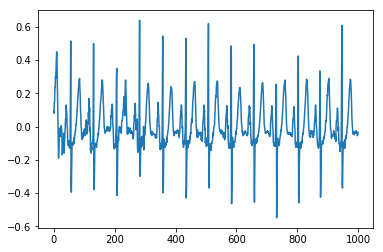

In [122]:
print(AllDataSegmented[1][5])
L = AllDataSegmented[1][5][16000:17000, 0]
plt.plot(L)
plt.show()

In [123]:
def sine_generator(fs, sinefreq, duration):
    T = duration
    nsamples = fs * T
    w = 2. * np.pi * sinefreq
    t_sine = np.linspace(0, T, nsamples, endpoint=False)
    y_sine = np.sin(w * t_sine)
    result = pd.DataFrame({'data' : y_sine} ,index=t_sine)
    return result

#High Pass filter

def butter_highpass(cutoff, fs, order=15):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=1):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


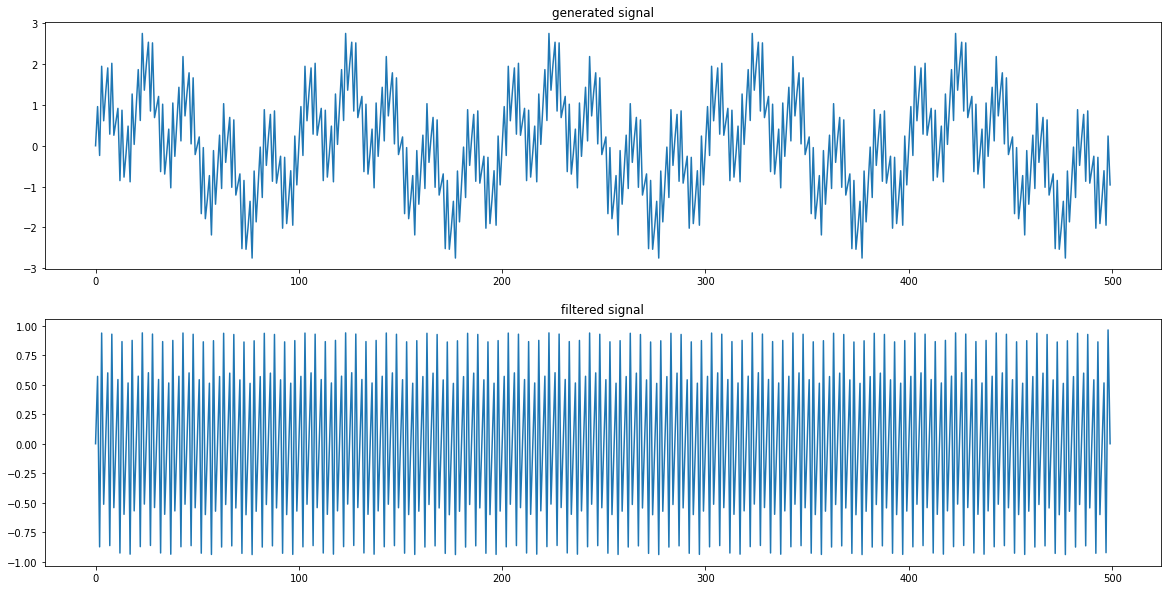

In [124]:
L = AllDataSegmented[4][3][:18000,0]

fps = 100
sine_fq = 5 #Hz
duration = 5 #seconds
sine_5Hz = sine_generator(fps,sine_fq,duration)
sine_fq = 1 #Hz
duration = 5 #seconds
sine_1Hz = sine_generator(fps,sine_fq,duration)

sine_fq = 40 #Hz
duration = 5 #seconds
sine_40Hz = sine_generator(fps,sine_fq,duration)

sine = sine_5Hz + sine_1Hz + sine_40Hz

filtered_sine = butter_highpass_filter(sine.data,20,fps)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(range(len(sine)),sine)
plt.title('generated signal')
plt.subplot(212)
plt.plot(range(len(filtered_sine)),filtered_sine)
plt.title('filtered signal')
plt.show()

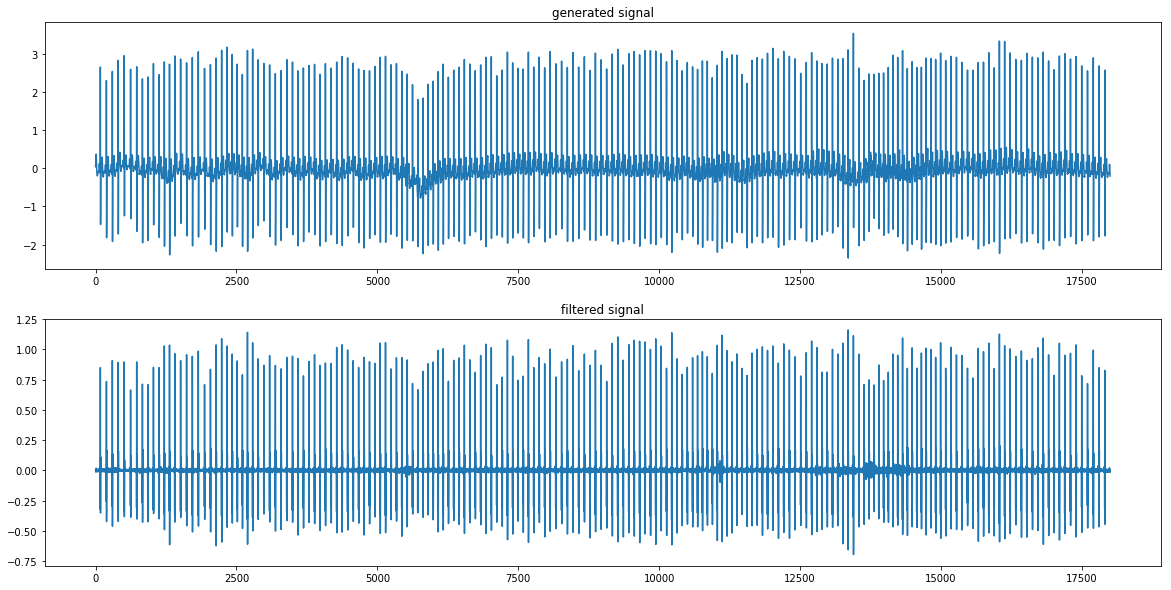

In [125]:
# Filtering using high pass filter to allow any frequency above 0.5 
# should remove respiratory artifacts (0.12Hz to 0.50HZ) ie 8-30 breaths per minute
#### BUT found that 20Hz cut off gave better suppression of non-R peak aspects of the ECG

# Trying data filtering
t_ECG = np.linspace(0,10, 18000, endpoint=False)
ECG = pd.DataFrame({'data' : L}, index=t_ECG)

filtered_ecg = butter_highpass_filter(ECG.data,20,fps)   # 20 here is the 20Hz cutoff

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(range(len(ECG)),ECG)
plt.title('generated signal')
plt.subplot(212)
plt.plot(range(len(filtered_ecg)),filtered_ecg)
plt.title('filtered signal')
plt.show()

In [126]:
MidDataSegments = []
for i in AllDataSegmented:
    MidSeg = i[75:(len(i))-75]
    MidDataSegments.append(MidSeg)

In [ ]:
AllDataFiltered = []
t_ECG = np.linspace(0,180, 18000, endpoint=False)    # Setup the index for the dataframe used
for i in MidDataSegments:
    SegmentsFiltered = []
    for j in i:
        TempSig = j[:18000,0]
        ECG = pd.DataFrame({'data' : TempSig}, index=t_ECG)
        filtered_ecg = butter_highpass_filter(ECG.data,20,fps)
        SegmentsFiltered.append(filtered_ecg)
    AllDataFiltered.append(SegmentsFiltered)
print(len(AllDataFiltered), AllDataFiltered)

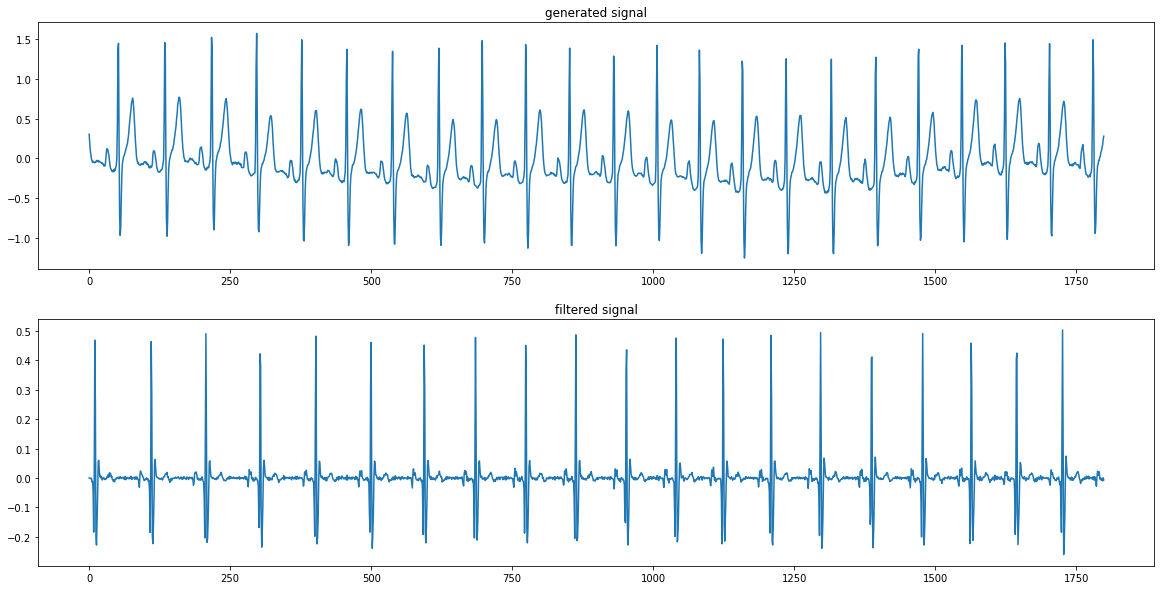

In [128]:
# Plot an example of one of the data segments and its filtered version

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(range(len(AllDataSegmented[16][3][:1800])),AllDataSegmented[16][3][:1800])
plt.title('generated signal')
plt.subplot(212)
plt.plot(range(len(AllDataFiltered[16][3][:1800])),AllDataFiltered[16][3][:1800])
plt.title('filtered signal')
plt.show()

In [129]:
cd /home/rishabkhincha/acads/3-2/sop/datasets/apnea-ecg

/home/rishabkhincha/acads/3-2/sop/datasets/apnea-ecg


In [132]:
!mkdir filtered1

In [133]:
cd filtered1

/home/rishabkhincha/acads/3-2/sop/datasets/apnea-ecg/filtered/filtered1


In [ ]:
# Create pkl file represenation of filtered data

iterate =0
for i in AllDataFiltered:
    filename = 'AllDataFiltered'
    filenumber = str(iterate)
    fileextension = '.pkl'
    name = filename+filenumber+fileextension
    joblib.dump(AllDataFiltered[iterate], name, compress=3)  
    print(name)
    iterate = iterate + 1


In [ ]:
def RRInterval(SegmentIn):
    overThres = [] 
    mean = SegmentIn.mean()
    std = SegmentIn.std()
    Thres = mean + (2 * std) # use criteria that peaks are at least 2 X std deviation above mean
    print(Thres)
    for i in SegmentIn:
        overThres.append(1*(i>Thres))    # Find those over the threshold 
    overThresnp = np.array(overThres)
    changes = overThresnp[2:18000]-overThresnp[1:17999]
    ndx = []
    for i in range(17998):
        if changes[i] > 0:
            ndx.append(i+2) 
    ndxlen=len(ndx)
    npndx =np.array(ndx)
    RRIntervals = npndx[2:ndxlen]-npndx[1:ndxlen-1]
    lenRR = len(RRIntervals)
    HRs = []
    for i in range(lenRR):
        HRs.append (6000/RRIntervals[i])
    return RRIntervals, HRs

In [ ]:
def RRCorrection (RRIntervalValues):
    Anp = np.array(RRIntervalValues)
    Amean = Anp.mean()
    A = RRIntervalValues
    for c in range(len(A)):
        if A[c] > Amean+(Amean/3):
            print(A[c])
            A[c] = Amean
            print(A[c])
        if A[c] < Amean-(Amean/3):
            print(A[c])
            A[c] = Amean
            print(A[c])
    return A

In [ ]:
def GetHeartRates (FilteredSig):
    AllHeartRates = []
    AllRRs = []
    SegmentRRs = []
    SegmentHRs = []
    iterate2 = 0
    for j in FilteredSig:
#         print("...")
#         print(iterate2)
        iterate2 = iterate2 + 1
        TempSig = j[:18000]
        TempRR, TempHR = RRInterval(TempSig)
        TempCorrectedHR = RRCorrection(TempHR)
        TempCorrectedRRInt = RRCorrection(TempRR)
        SegmentHRs.append(TempCorrectedHR)
        SegmentRRs.append(TempCorrectedRRInt)
    AllHeartRates.append(SegmentHRs)
    AllRRs.append(SegmentRRs)
    return AllRRs, AllHeartRates

In [ ]:
i=0
tmp1, tmp2 = GetHeartRates (AllDataFiltered[i])

In [ ]:
'''Calc NN50 measure (variant 1), defined as the number of pairs of adjacent RR- intervals 
where the first RR- interval exceeds the second RR- interval by more than 50 ms.
Note my calc is not strictly NN50 because the resolution doesn't show if it's 51ms only if it's 60ms greater
'''

def NN50 (RRintervals):
    NN50_count = 0
    temp = 999
    for i in RRintervals:
        if (temp - i) > 5:
            NN50_count = NN50_count + 1
        temp = i
    return NN50_count


In [ ]:
'''The NN50 measure (variant 2), defined as the number of pairs of adjacent RR-intervals where the 
second RR- interval exceeds the first RR interval by more than 50 ms
'''
def NN50_count2 (RRint):
    NN50_count2 = 0
    temp = 999
    for i in RRint:
        if (i - temp) > 5:
            NN50_count2 = NN50_count2 + 1
        temp = i
    return NN50_count2


In [ ]:
def HRstats_new(RRArray, HRArray,HRm,HRs,NN501,NN502):
    for i in HRArray:
        #print (i)
        HRm.append(np.mean(i))
        HRs.append(np.std(i))
    for i in RRArray:
        NN501.append(NN50(i))
        NN502.append(NN50_count2(i))
    return HRm,HRs,NN501,NN502

In [ ]:
datafeatures = []        #Hashing this out to allow appending the next lot of data
classifys = []           #Hashing this out to allow appending the next lot of data

In [ ]:
def prepclassifiercontainers(datafeatures, classifys):
    iterate = 0
    if len(MyAnn) < len(HRmean):
        for i in MyAnn:
            data_features = []
            data_features.append(HRmean[iterate])
            data_features.append(HRstd[iterate])
            data_features.append(NN50Result[iterate])
            data_features.append(NN502Result[iterate])
            classifys.append(MyAnn[iterate])
            iterate=iterate+1
            datafeatures.append(data_features)
    else:
        for i in HRmean:                 
            data_features = []
            data_features.append(HRmean[iterate])
            data_features.append(HRstd[iterate])
            data_features.append(NN50Result[iterate])
            data_features.append(NN502Result[iterate])
            classifys.append(MyAnn[iterate])
            iterate=iterate+1
            datafeatures.append(data_features)
    return datafeatures, classifys

In [ ]:
def Annot(sigfile):
    annotation = wfdb.rdann(sigfile, 'apn')
    AnnSym = annotation.symbol
    MyAnn = [] # initialise the container
    for i in range (len(AnnSym)-149):             # Using only the mid section of the signal so taking 75 minutes off each end 
        if AnnSym[i+74] == 'A' or AnnSym[i+75] == 'A' or AnnSym[i+76] == 'A': 
            Ann = 'A'
        else :
            Ann = 'N'
        MyAnn.append(Ann)
    return MyAnn

In [ ]:
AllHR=[]
AllRR=[]
for i in range(len(AllDataFiltered)):
    tmp1, tmp2 = GetHeartRates (AllDataFiltered[i])
    AllHR.append(tmp2)
    AllRR.append(tmp1)
print(len(AllRR), len(AllHR))

In [145]:
datafeatures = []
classifys = []

In [32]:
datafeatures = []
classifys = []
for i in range(len(AllDataFiltered)):
    HRmean = []
    HRstd = []
    NN50Result = []
    NN502Result = []
    HRstats_new(AllRR[i][0], AllHR[i][0], HRmean, HRstd, NN50Result, NN502Result) 
            ## Change this  to the signal file you're populating featuress from
    MyAnn = Annot('/home/rishabkhincha/acads/3-2/sop/datasets/apnea-ecg/'+ECGFiles[i])   ## Change this each time to the signal file you're populating labels from
    datafeatures, classifys = prepclassifiercontainers(datafeatures, classifys)
    print(len(datafeatures), len(classifys))


NameError: name 'HRstats_new' is not defined

In [26]:
# print(len(datafeatures), len(classifys))
len(datafeatures), len(classifys), datafeatures,  classifys

NameError: name 'datafeatures' is not defined

In [183]:
iterate = 0
for i in datafeatures:
    i.append(classifys[iterate])
    iterate = iterate + 1

In [184]:
import random
random.shuffle(datafeatures)

In [185]:
classifys = []
iterate = 0
for i in datafeatures:
    classifys.append(i[4])
    i.pop(4)

In [193]:
datafeatures1=[]
classifys1=[]
for i in range(len(datafeatures)):
    if(np.isnan(datafeatures[i]).any()!=True):
        datafeatures1.append(datafeatures[i])
        classifys1.append(classifys[i])
len(datafeatures1), len(classifys1), datafeatures1, classifys1
datafeatures = datafeatures1
classifys = classifys1

In [27]:
filename = 'classifys_shuffled.pkl'
pickle.dump(classifys, open(filename, 'wb'))
filename = 'datafeatures_shuffled.pkl'
pickle.dump(datafeatures, open(filename, 'wb'))

NameError: name 'classifys' is not defined

In [32]:
filename = 'classifys_shuffled.pkl'
classifys = pickle.load(open(filename, 'rb'))
filename = 'datafeatures_shuffled.pkl'
datafeatures = pickle.load(open(filename, 'rb'))

dflen = len(datafeatures)
split = int(7*dflen/10)            # Split is 9/10 of the total dataset

In [33]:
#Running the SVM (support vector model)
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

svm = SVC(C=1.0, gamma='auto', kernel='rbf')
svm.fit(datafeatures[:split], classifys[:split])        # We're training on just the data features up to the split

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
# Make an array of predictions on the validation set
predictions = svm.predict(datafeatures[split+1:dflen-1])        # getting predictions based on the held back validation

# Output the percentage accuracy, total predicted correctly and the confusion matrix for each model
print(svm.score(datafeatures[split+1:dflen-1], classifys[split+1:dflen-1]))
print(confusion_matrix(predictions, classifys[split+1:dflen-1]))
cm = confusion_matrix(predictions, classifys[split+1:dflen-1])

0.7967017344327552
[[1032  209]
 [ 506 1770]]


Confusion matrix, without normalization
[[1032  209]
 [ 506 1770]]


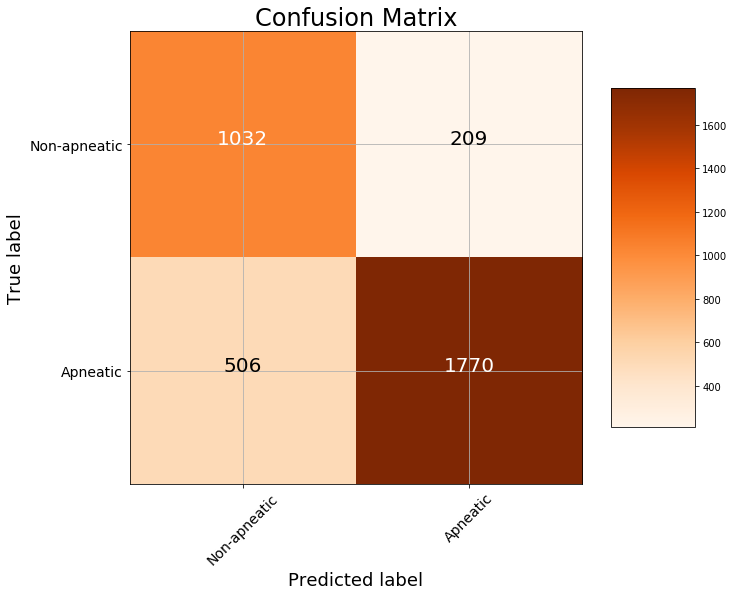

In [35]:
plot_confusion_matrix(cm, classes = ['Non-apneatic', 'Apneatic'], normalize=False, title = 'Confusion Matrix')

In [57]:
filename = 'svm1.pkl'
pickle.dump(svm, open(filename, 'wb'))

In [58]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [59]:
svm = SVC(C=1.0, gamma=0.1, kernel='rbf')
svm.fit(datafeatures[:split], classifys[:split])        # We're training on just the dataset up to the split

# Make an array of predictions on the validation set
predictions = svm.predict(datafeatures[split+1:dflen-1])        # getting predictions based on the held back validation set

# Output the percentage accuracy, total predicted correctly and the confusion matrix for each model
print(svm.score(datafeatures[split+1:dflen-1], classifys[split+1:dflen-1]))
print(confusion_matrix(predictions, classifys[split+1:dflen-1]))
cm=confusion_matrix(predictions, classifys[split+1:dflen-1])

0.838599487617421
[[395  70]
 [119 587]]


Confusion matrix, without normalization
[[395  70]
 [119 587]]


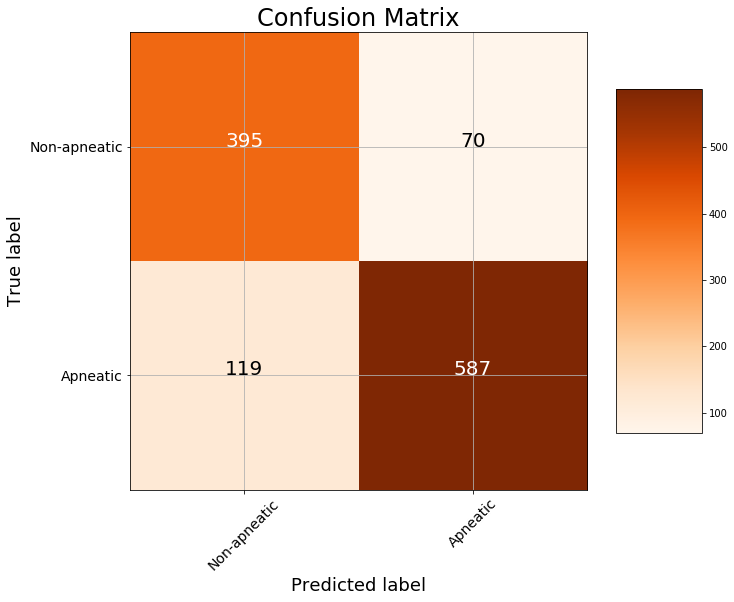

In [60]:
plot_confusion_matrix(cm, classes = ['Non-apneatic', 'Apneatic'], normalize=False, title = 'Confusion Matrix')

In [61]:
filename = 'svm2.pkl'
pickle.dump(svm, open(filename, 'wb'))

In [36]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

0.8180267273244243
[[1286  388]
 [ 252 1591]]
Confusion matrix, without normalization
[[1286  388]
 [ 252 1591]]


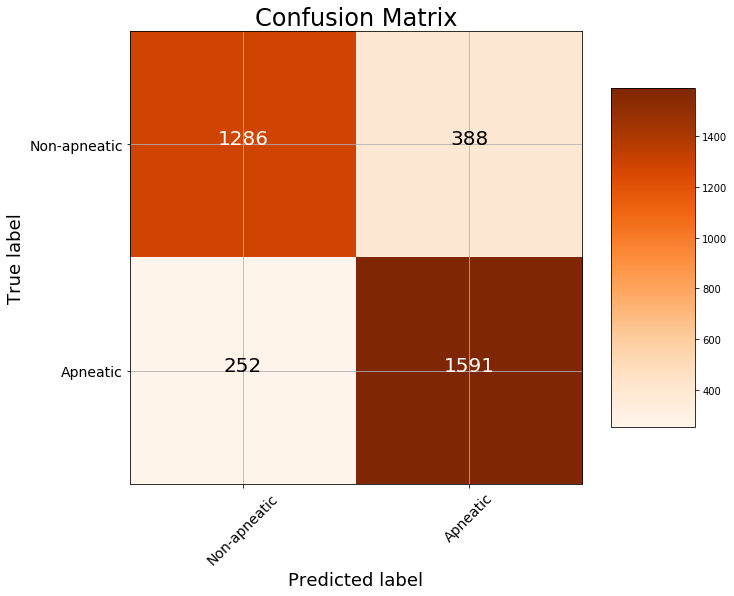

In [37]:
classifier = RandomForestClassifier()

classifier.fit(datafeatures[:split], classifys[:split])

# Make an array of predictions on the validation set
predictions = classifier.predict(datafeatures[split+1:dflen-1])

# Output the percentage accuracy, total predicted correctly and the confusion matrix for each model
print(classifier.score(datafeatures[split+1:dflen-1], classifys[split+1:dflen-1]))
print(confusion_matrix(predictions, classifys[split+1:dflen-1]))
cm = confusion_matrix(predictions, classifys[split+1:dflen-1])
plot_confusion_matrix(cm, classes = ['Non-apneatic', 'Apneatic'], normalize=False, title = 'Confusion Matrix')

In [38]:
filename = 'RF_Class.pkl'
pickle.dump(classifier, open(filename, 'wb'), protocol=2)

0.8146883005977796
[[424 127]
 [ 90 530]]
Confusion matrix, without normalization
[[424 127]
 [ 90 530]]


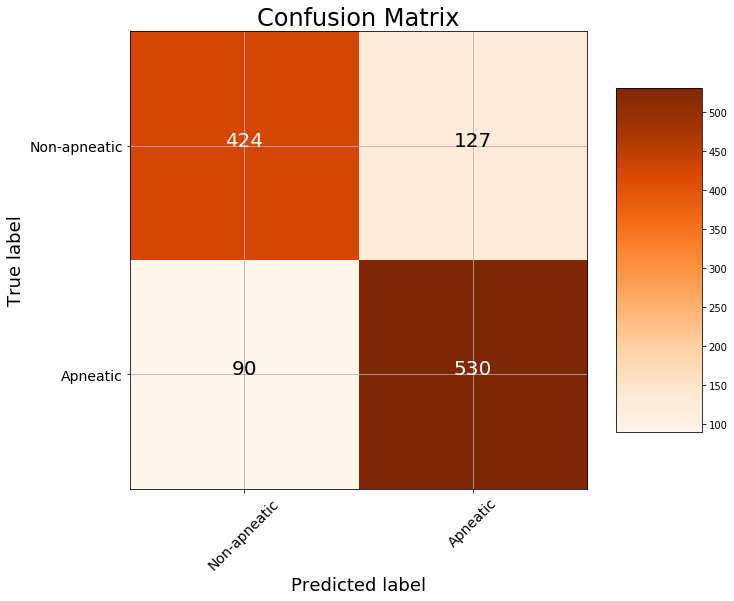

In [65]:
classifier = SVC(C=10, gamma=0.001, kernel='rbf')

classifier.fit(datafeatures[:split], classifys[:split])

# Make an array of predictions on the validation set
predictions = classifier.predict(datafeatures[split+1:dflen-1])

# Output the percentage accuracy, total predicted correctly and the confusion matrix for each model
print(classifier.score(datafeatures[split+1:dflen-1], classifys[split+1:dflen-1]))
print(confusion_matrix(predictions, classifys[split+1:dflen-1]))
cm = confusion_matrix(predictions, classifys[split+1:dflen-1])
plot_confusion_matrix(cm, classes = ['Non-apneatic', 'Apneatic'], normalize=False, title = 'Confusion Matrix')

0.8411614005123825
[[419  91]
 [ 95 566]]
Confusion matrix, without normalization
[[419  91]
 [ 95 566]]


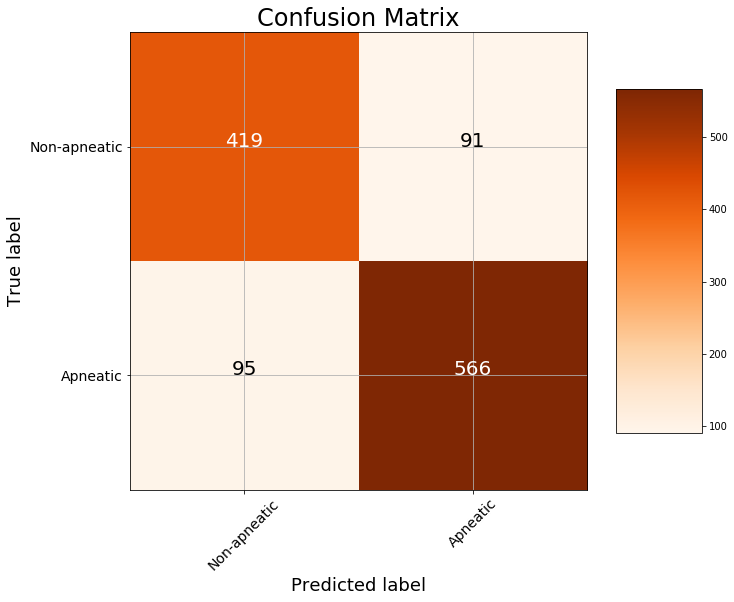

In [66]:
classifier = KNeighborsClassifier()

classifier.fit(datafeatures[:split], classifys[:split])

# Make an array of predictions on the validation set
predictions = classifier.predict(datafeatures[split+1:dflen-1])

# Output the percentage accuracy, total predicted correctly and the confusion matrix for each model
print(classifier.score(datafeatures[split+1:dflen-1], classifys[split+1:dflen-1]))
print(confusion_matrix(predictions, classifys[split+1:dflen-1]))
cm = confusion_matrix(predictions, classifys[split+1:dflen-1])
plot_confusion_matrix(cm, classes = ['Non-apneatic', 'Apneatic'], normalize=False, title = 'Confusion Matrix')

In [67]:
pickle.dump(classifier, open('KNear.pkl', 'wb'), protocol=0)  

0.8061485909479078
[[395 108]
 [119 549]]
Confusion matrix, without normalization
[[395 108]
 [119 549]]


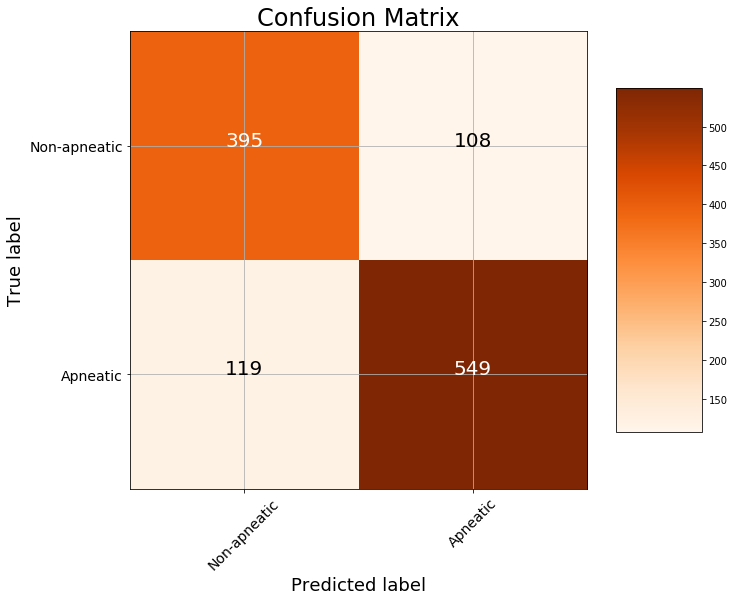

In [68]:
classifier = DecisionTreeClassifier()

classifier.fit(datafeatures[:split], classifys[:split])

# Make an array of predictions on the validation set
predictions = classifier.predict(datafeatures[split+1:dflen-1])

# Output the percentage accuracy, total predicted correctly and the confusion matrix for each model
print(classifier.score(datafeatures[split+1:dflen-1], classifys[split+1:dflen-1]))
print(confusion_matrix(predictions, classifys[split+1:dflen-1]))



In [111]:
import random
seed=2
random.seed(seed)

/home/rishabkhincha/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 79.16%
Confusion matrix, without normalization
[[416 146]
 [ 98 511]]


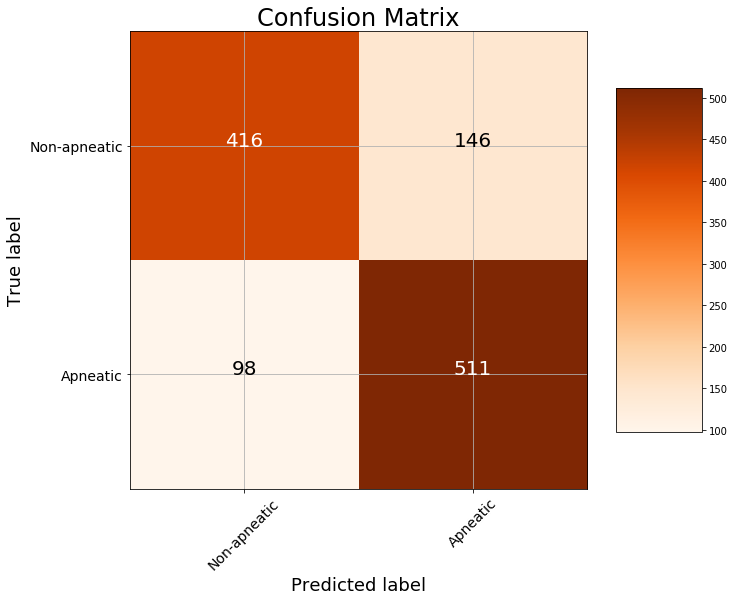

In [112]:
from xgboost import XGBClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
model = XGBClassifier()
model.fit(np.asarray(datafeatures[:split]), np.asarray(classifys[:split]))
# make predictions for test data
predictions = model.predict(datafeatures[split+1:dflen-1])
# evaluate predictions
accuracy = accuracy_score(classifys[split+1:dflen-1], predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
cm = confusion_matrix(predictions, classifys[split+1:dflen-1])
plot_confusion_matrix(cm, classes = ['Non-apneatic', 'Apneatic'], normalize=False, title = 'Confusion Matrix')

In [95]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30, 50, 20), max_iter=1000)  
mlp.fit(datafeatures[:split], classifys[:split])  

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 50, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [96]:
predictions = mlp.predict(datafeatures[split+1:dflen-1])  

In [17]:
from sklearn.metrics import classification_report, confusion_matrix  

[[345 169]
 [ 97 560]]
             precision    recall  f1-score   support

          A       0.78      0.67      0.72       514
          N       0.77      0.85      0.81       657

avg / total       0.77      0.77      0.77      1171

Confusion matrix, without normalization
[[345  97]
 [169 560]]


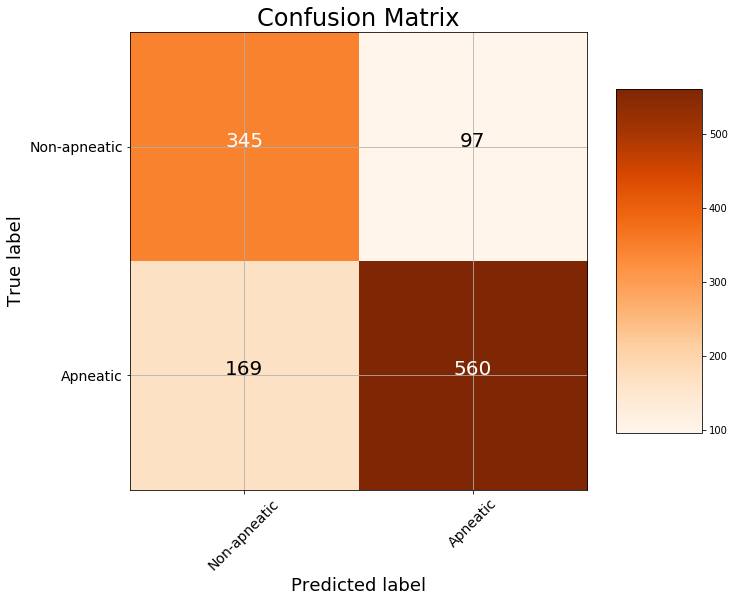

In [97]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(classifys[split+1:dflen-1],predictions))
cm=confusion_matrix(classifys[split+1:dflen-1],predictions)
print(classification_report(classifys[split+1:dflen-1],predictions))  
cm = confusion_matrix(predictions, classifys[split+1:dflen-1])
plot_confusion_matrix(cm, classes = ['Non-apneatic', 'Apneatic'], normalize=False, title = 'Confusion Matrix')

In [10]:
ls

AllDataFiltered0.pkl   AllDataFiltered22.pkl  AllDataFiltered3.pkl
AllDataFiltered10.pkl  AllDataFiltered23.pkl  AllDataFiltered4.pkl
AllDataFiltered11.pkl  AllDataFiltered24.pkl  AllDataFiltered5.pkl
AllDataFiltered12.pkl  AllDataFiltered25.pkl  AllDataFiltered6.pkl
AllDataFiltered13.pkl  AllDataFiltered26.pkl  AllDataFiltered7.pkl
AllDataFiltered14.pkl  AllDataFiltered27.pkl  AllDataFiltered8.pkl
AllDataFiltered15.pkl  AllDataFiltered28.pkl  AllDataFiltered9.pkl
AllDataFiltered16.pkl  AllDataFiltered29.pkl  classifys_shuffled.pkl
AllDataFiltered17.pkl  AllDataFiltered2.pkl   datafeatures_shuffled.pkl
AllDataFiltered18.pkl  AllDataFiltered30.pkl  filtered1/
AllDataFiltered19.pkl  AllDataFiltered31.pkl  KNear.pkl
AllDataFiltered1.pkl   AllDataFiltered32.pkl  RF_Class.pkl
AllDataFiltered20.pkl  AllDataFiltered33.pkl  svm1.pkl
AllDataFiltered21.pkl  AllDataFiltered34.pkl  svm2.pkl


In [39]:
import pickle
filename = 'RF_Class.pkl'
rf_classifier = pickle.load(open(filename, 'rb'))
filename = 'classifys_shuffled.pkl'
classifys = pickle.load(open(filename, 'rb'))
filename = 'datafeatures_shuffled.pkl'
datafeatures = pickle.load(open(filename, 'rb'))

In [40]:
len(classifys), len(datafeatures)

(11728, 11728)

0.9357946793997272
[[4889  475]
 [ 278 6086]]
Confusion matrix, without normalization
[[4889  475]
 [ 278 6086]]


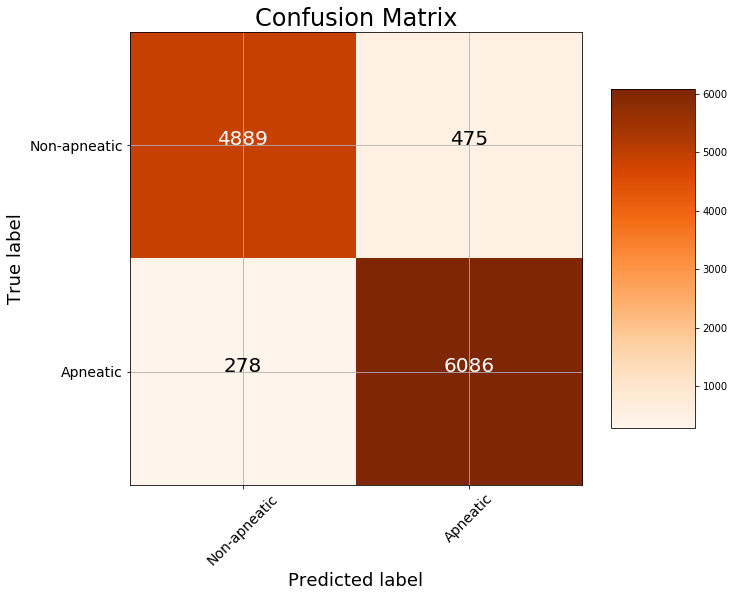

In [41]:
# Make an array of predictions on the validation set
predictions = rf_classifier.predict(datafeatures)

# Output the percentage accuracy, total predicted correctly and the confusion matrix for each model
print(rf_classifier.score(datafeatures, classifys))
print(confusion_matrix(predictions, classifys))
cm = confusion_matrix(predictions, classifys)
plot_confusion_matrix(cm, classes = ['Non-apneatic', 'Apneatic'], normalize=False, title = 'Confusion Matrix')